# Bearing  RUL Prediction

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.fftpack import fft
from sklearn.decomposition import PCA

## Import libraries for the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'bearing'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['s1-c1',
 's1-c2',
 's1-c3',
 's1-c4',
 's1-c5',
 's1-c6',
 's1-c7',
 's1-c8',
 's2-c1',
 's2-c2',
 's2-c3',
 's2-c4',
 's3-c1',
 's3-c2',
 's3-c3',
 's3-c4']

## Converting TAG Name Format
* After checking all the Tag Names from the Nasa bearing dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names related to the s1-c5

In [5]:
# Set the desired tag names
tags = ['s1-c5']

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

's1-c5'


## Loading Nasa Bearing Dataset
* Load the train, validation, and test datasets separately when loading the data.
* The example focuses on anomaly detection for the 3rd bearing -> using 's1-c5' as the Tag Name.
* Label all states except for the faulty condition as normal for the labeling process.

In [6]:
# Set the status of each bearing based on time ranges
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

In [7]:
# Data loading parameter settings

# Set the tag table name
table = 'bearing'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = quote('2006-01-02 15:04:05.000000')
# Set the data start time
start_time = quote('2003-10-22 12:06:24')
# Set the data end time
end_time = quote('2003-11-25 23:39:56')

In [8]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')
    
    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()
    
    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Group by seconds and count the number of records
    df_counts = df.groupby(df['TIME'].dt.floor('S')).size().reset_index(name='count')

    # Filter groups with the same number of records
    # Select the most common count values
    most_common_count = df_counts['count'].mode()[0]

    # Filter by the most common count value
    filtered_df_counts = df_counts[df_counts['count'] == most_common_count]

    # Convert filtered time values to a list
    filtered_times = filtered_df_counts['TIME'].tolist()

    # Select only the filtered time values from the original DataFrame
    filtered_data = df[df['TIME'].dt.floor('S').isin(filtered_times)]

    # Group by TIME
    # Round to the nearest second
    filtered_data_ = filtered_data.copy()
    filtered_data_.loc[:, 'TIME'] = filtered_data_['TIME'].dt.floor('S')
    grouped = filtered_data_.groupby('TIME')['s1-c5'].apply(list).reset_index()

    # Split the list into individual columns
    s1_c5_df = pd.DataFrame(grouped['s1-c5'].tolist())

    # Merge with the 'TIME' column
    result_df = pd.concat([grouped[['TIME']], s1_c5_df], axis=1)
    
    # Set labels
    # Assign labels based on abnormal time ranges for each channel data
    result_df['label'] = np.where((result_df['TIME'] >= "2003-11-25 10:57:32") & (result_df['TIME'] <= "2003-11-25 23:39:56"), 1, 0)
    
    result_df = result_df.drop(['TIME'], axis=1)

    return result_df

In [9]:
# Load data
df = data_load(table, name, start_time, end_time, timeformat)
df

,0,1,2,3,4,5,6,7,8,9,...,20471,20472,20473,20474,20475,20476,20477,20478,20479,label
0,-0.105,-0.049,-0.005,-0.100,-0.151,0.046,-0.132,-0.164,-0.110,-0.100,...,-0.088,-0.107,-0.078,-0.093,-0.200,-0.159,-0.237,-0.027,-0.002,0
1,-0.083,-0.132,-0.081,-0.022,-0.129,-0.110,-0.149,-0.168,-0.225,-0.217,...,-0.129,-0.149,-0.046,0.007,-0.132,-0.073,0.056,-0.186,-0.049,0
2,-0.122,-0.244,-0.156,-0.076,0.046,-0.098,-0.142,0.083,-0.195,-0.088,...,-0.107,-0.061,-0.090,-0.049,-0.125,-0.056,-0.137,-0.247,-0.229,0
3,-0.210,-0.125,-0.090,-0.215,-0.225,-0.139,-0.042,-0.090,-0.142,-0.232,...,-0.046,-0.195,-0.085,-0.112,-0.049,-0.146,-0.154,-0.220,-0.090,0
4,-0.088,-0.088,-0.110,-0.269,0.024,-0.054,-0.156,-0.205,-0.056,-0.132,...,0.044,-0.122,-0.115,-0.056,-0.078,-0.002,-0.342,-0.173,-0.161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,-0.212,-0.095,0.044,0.005,-0.364,-0.239,-0.098,-0.066,-0.081,-0.164,...,-0.574,0.127,0.767,0.173,0.217,-0.271,0.085,0.364,-0.166,1
2151,0.432,0.217,-0.627,-0.308,0.073,0.107,-0.359,0.056,-0.159,-0.181,...,-0.161,-0.046,-0.098,-0.186,-0.251,-0.032,-0.017,-0.073,-0.437,1
2152,-0.112,-0.510,0.037,0.063,-0.115,-0.066,0.117,0.405,-0.374,-0.339,...,-0.188,-0.002,-0.085,-0.149,-0.195,-0.227,-0.095,-0.115,-0.293,1
2153,-0.593,0.366,-0.393,-0.312,-0.156,0.288,0.122,-0.105,0.242,-0.166,...,0.510,-0.776,-0.483,0.288,0.359,0.120,-0.173,-0.400,0.505,1


In [10]:
# Split the data into train, validation, and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)
valid, test = train_test_split(test, test_size=0.5, shuffle=False)

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

## Data Preprocessing 1

* 1 hanning window
* 2 FFT
* 3 MinMax Scaling
* 4 PCA

### 1. Applying Hanning Window

In [11]:
# Hanning window function setup 
def set_hanning_window(sample_rate, df):
    
    # Generate Hanning window
    hanning_window = np.hanning(sample_rate)

    # Apply Hanning window to each row
    df_windowed = df.multiply(hanning_window, axis=1)
    
    return df_windowed

In [12]:
# Sampling period -> Number of data points per second
window_length = len(df.columns[:-1])

# Applying Hanning Window
train_ = set_hanning_window(window_length, train.iloc[:,:-1])
valid_ = set_hanning_window(window_length, valid.iloc[:,:-1])
test_ = set_hanning_window(window_length, test.iloc[:,:-1])

### 2. Applying FFT (Fast Fourier Transform)

In [13]:
# FFT transformation function
def change_fft(sample_rate, df):
    # Total number of samples in the signal
    N = sample_rate
    
    fft_results = np.zeros((df.shape[0], N // 2 + 1), dtype=float)
    
    # Apply FFT to each row
    for i in range(df.shape[0]):
        
        # Calculate FFT for each row
        yf = fft(df.iloc[i].values)
        
        # Compute the absolute value of the FFT results and normalize (only the meaningful part)
        fft_results[i] = 2.0 / N * np.abs(yf[:N // 2 + 1])
    
    # Convert FFT results to a DataFrame
    fft_df = pd.DataFrame(fft_results)
    
    return fft_df

In [14]:
# Sampling period -> Number of data points per second
sampling_rate = len(df.columns[:-1])

# Applying FFT (Fast Fourier Transform)
train_ = change_fft(sampling_rate, train_)
valid_ = change_fft(sampling_rate, valid_)
test_ = change_fft(sampling_rate, test_)

### 3. Applying MinMaxScaler

In [15]:
# Scaler Setup
scaler = MinMaxScaler()

# Apply Scaler
train_ = scaler.fit_transform(train_.values)
valid_ = scaler.transform(valid_.values)
test_ = scaler.transform(test_.values)

# Set DataFrames
train_scaled = pd.DataFrame(train_)
valid_scaled = pd.DataFrame(valid_)
test_scaled = pd.DataFrame(test_)

### 4. Applying PCA (Principal Component Analysis)

In [16]:
## Applying PCA
# Select principal components explaining 95% of the variance
pca = PCA(n_components=0.95)

# Apply PCA
train_scaled_ = pca.fit_transform(train_scaled)
valid_scaled_ = pca.transform(valid_scaled)
test_scaled_ = pca.transform(test_scaled)

# Set DataFrames
train_scaled_ = pd.DataFrame(train_scaled_)
valid_scaled_ = pd.DataFrame(valid_scaled_)
test_scaled_ = pd.DataFrame(test_scaled_)

# Add labels
train_scaled_['label'] = train['label'].values
valid_scaled_['label'] = valid['label'].values
test_scaled_['label'] = test['label'].values

print(train_scaled_['label'].value_counts())
print(valid_scaled_['label'].value_counts())
print(test_scaled_['label'].value_counts())

label
0    1724
Name: count, dtype: int64
label
0    215
Name: count, dtype: int64
label
0    181
1     35
Name: count, dtype: int64


## Dataset & Loader Setup 1

### Window Dataset Configuration
* To train on time series data, you need to set the window size and the sliding step.

* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [17]:
# Sliding Window Dataset setup
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size, step_size):
        self.data = data
        self.window_size = window_size
        self.step_size = step_size
        self.windows, self.labels = self._create_windows()
    
    # Set up sliding windows
    def _create_windows(self):
        windows = []
        labels = []
        for i in range(0, len(self.data) - self.window_size + 1, self.step_size):
            window = self.data.iloc[i:i + self.window_size, :-1].values  # Exclude the last column
            label_array = self.data.iloc[i:i + self.window_size, -1].values  # The last column is the label
            
            # Set the label to 1 if there is any abnormal value in the label array
            if (label_array == 1).any():
                label = 1  
            else:
                label = 0
                
            windows.append(torch.Tensor(window))
            labels.append(torch.Tensor([label]))  # Convert label to Tensor
        return windows, labels
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

In [35]:
# Sliding window configuration
window_size = 3
step_size = 1 

# Set up datasets 
train_ = SlidingWindowDataset(train_scaled_, window_size, step_size)
valid_ = SlidingWindowDataset(valid_scaled_, window_size, step_size)
test_ = SlidingWindowDataset(test_scaled_, window_size, step_size)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=32, shuffle=False)
valid_dataloader = DataLoader(valid_, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=1, shuffle=False)

In [36]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([32, 3, 1487])


## Health Index Extraction Model Configuration
* Using LSTM AE model.

In [37]:
# LSTM Autoencoder class definition
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, 2*hidden_dim)
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Encoder part
        _, (h, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h[-1])
        
        # Decoder part
        hidden = self.decoder_fc(latent).unsqueeze(0).repeat(x.size(1), 1, 1).permute(1, 0, 2)
        output, _ = self.decoder_lstm(hidden)
        
        return output

In [38]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0][0].shape)
input_dim = 1487

# LSMT hidden state size
hidden_dim = 256

# layer size
num_layers = 3

# Learning rate 
learning_rate = 0.01

# Model configuration
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

LSTMAutoencoder(
  (encoder_lstm): LSTM(1487, 256, num_layers=3, batch_first=True)
  (encoder_fc): Linear(in_features=256, out_features=512, bias=True)
  (decoder_fc): Linear(in_features=512, out_features=256, bias=True)
  (decoder_lstm): LSTM(256, 1487, num_layers=3, batch_first=True)
)


## Health Index Extraction Model Training

* Save the model with the Best Loss based on the training data during training.

In [22]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(10, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    preds_ = []
    targets_ = []

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)
 
        # Calculate loss 
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Nasa_Bearing_General_Health_Index.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/10 [00:00<?, ?it/s]


train loss: 0.178640305156561
Model saved

train loss: 0.17811182013882648
Model saved

train loss: 0.17793222426491287
Model saved

train loss: 0.17784242630632258
Model saved

train loss: 0.17778854749568943
Model saved

train loss: 0.17775262827922614
Model saved

train loss: 0.17772697167687698
Model saved

train loss: 0.17770772925486117
Model saved

train loss: 0.1776927629218192
Model saved

train loss: 0.17768078985322228
Model saved


## Health Index Extraction

In [39]:
# Load the best Health Index Extraction model
model_ = torch.load(f'./result/Nasa_Bearing_General_Health_Index.pt') 

In [40]:
# Extract validation data Health Index
Train_Health_Index = []
with torch.no_grad():
    
    for batch_idx, valid_data in enumerate(valid_dataloader):

        inputs_val = valid_data[0].to(device).float()

        outputs_val = model_(inputs_val)
        loss = criterion(outputs_val, inputs_val)
        
        Train_Health_Index.append(loss.item())

In [41]:
# Extract test data Health Index
Test_Health_Index = []
with torch.no_grad():
    model_.eval()
    for batch_idx, test_data in enumerate(test_dataloader):

        inputs_test = test_data[0].to(device).float()
        label = test_data[1].to(device).long()

        outputs_test = model_(inputs_test)
        loss = criterion(outputs_test, inputs_test)
        
        Test_Health_Index.append(loss.item())

## Data Preprocessing 2

* 1 MinMax Scaling

In [42]:
# Convert Health_Index to a numpy array
Train_Health_Index = np.array(Train_Health_Index).reshape(-1, 1)
Test_Health_Index = np.array(Test_Health_Index).reshape(-1, 1)

# Set up MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax Scaling
Train_Health_Index = scaler.fit_transform(Train_Health_Index)
Test_Health_Index = scaler.transform(Test_Health_Index)

# Set DataFrame
Train_Health_Index = Train_Health_Index
Train_Health_Index = pd.DataFrame(Train_Health_Index)

Test_Health_Index  = Test_Health_Index
Test_Health_Index = pd.DataFrame(Test_Health_Index)

## Dataset & Loader Setup 2

### Window Dataset Configuration
* To train on time series data, you need to set the window size and the sliding step.

* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [43]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# Sliding window configuration
# Window size: How many past data points will be used
# Forecast: How many future data points to forecast
window_size = 10
forecast_size= 5

# Set up datasets 
train_x, train_y = time_slide_df(Train_Health_Index, window_size, forecast_size)
test_x, test_y = time_slide_df(Test_Health_Index, window_size, forecast_size)

train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

train_dataloader_ = DataLoader(train_ds, batch_size = 16, shuffle=False)
test_dataloader_ = DataLoader(test_ds,  batch_size = 16, shuffle=False)

## Health Index Prediction Model Configuration
* Using DLinear model.

In [45]:
## modeling
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - 0.3*moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size

        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:

            trend_output = self.Linear_Trend(trend_init)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [46]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Model configuration
model = LTSF_DLinear(
                    window_size=window_size,
                    forecast_size=forecast_size,
                    kernel_size=25,
                    individual=False,
                    feature_size=1
                    ).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=10, out_features=5, bias=True)
  (Linear_Seasonal): Linear(in_features=10, out_features=5, bias=True)
)


## Health Index Prediction Model Training

* Save the model with the Best Loss based on the training data during training.

In [32]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader_)
# Set number of epochs
epoch_in = trange(500, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:

    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader_):
        
        data = data.to(device).float()
        target = target.to(device).float()
        
        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(data)

        # Calculate loss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Nasa_Bearing_General_RUL.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/500 [00:00<?, ?it/s]


train loss: 0.10219974901813728
Model saved

train loss: 0.08636375602621299
Model saved

train loss: 0.0749414333452781
Model saved

train loss: 0.06669514973719533
Model saved

train loss: 0.060646984926783123
Model saved

train loss: 0.056080841626494356
Model saved

train loss: 0.05252639456027812
Model saved

train loss: 0.04968202934385492
Model saved

train loss: 0.04734888031250901
Model saved

train loss: 0.045391923361099686
Model saved

train loss: 0.043717906432604044
Model saved

train loss: 0.04226154330162666
Model saved

train loss: 0.04097637184757806
Model saved

train loss: 0.03982869018340013
Model saved

train loss: 0.038793554453131485
Model saved

train loss: 0.037852127163205296
Model saved

train loss: 0.03698990468306644
Model saved

train loss: 0.03619551702410492
Model saved

train loss: 0.035459904279182795
Model saved

train loss: 0.034775739245546555
Model saved

train loss: 0.034137016759277924
Model saved

train loss: 0.03353875447585658
Model saved

t

## Model Testing

In [47]:
# Load the best model
model_ = torch.load(f'./result/Nasa_Bearing_General_RUL.pt')

In [48]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, (data, target) in enumerate(test_dataloader_):
        
        data_t = data.to(device).float()
        target_t = target.to(device).float()

        outputs_t = model_(data_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[:,:1].cpu().numpy().reshape(-1, 1)
last_values_pred = combined_tensor_pred[:,:1].cpu().numpy().reshape(-1, 1)

## Model Performance Evaluation

In [49]:
# Calculate MSE
mse = mean_squared_error(last_values_target, last_values_pred)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(last_values_target, last_values_pred)
print("R² Score:", r2)

Mean Squared Error: 0.8097637
R² Score: 0.968874831333223


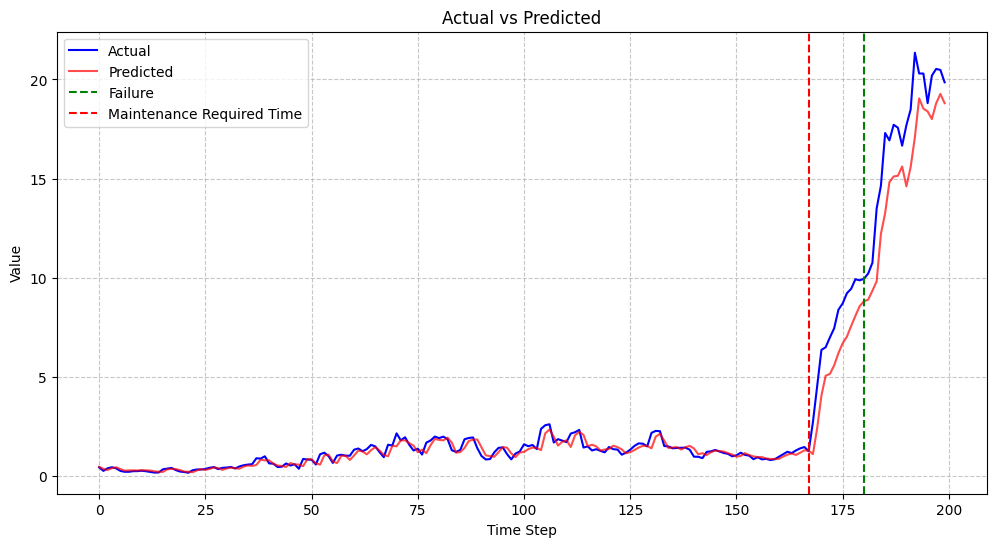

In [50]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(last_values_target, label='Actual', color='blue')
plt.plot(last_values_pred, label='Predicted', color='red', alpha=0.7)

# Add a vertical line at the 180th position (failure point)
plt.axvline(x=180, color='green', linestyle='--', linewidth=1.5, label='Failure')
# Add a vertical line at the 167th position (maintenance required point)
plt.axvline(x=167, color='red', linestyle='--', linewidth=1.5, label='Maintenance Required Time')

# Set graph title and axis labels
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Display the graph
plt.show()